In [ ]:
'''
#写真の読み込み

# ダウンロードしたいフォルダを zip 圧縮する
# !zip -r /content/drive/MyDrive/自分用/BMI/picture/A_pictures

# 圧縮した zip ファイルをダウンロードする
# from google.colab import files
# files.download("/content/drive/MyDrive/自分用/BMI/picture/A_pictures")


#ファイル名が入ったリストを作る
import os

picture_list={'A','B','C','E'}

for picture_character in picture_list:

    path = f'/content/drive/MyDrive/自分用/BMI/picture/{picture_character}_pictures'

    files = os.listdir(path)
    files_file = [f for f in files if os.path.isfile(os.path.join(path, f))]
    print(files_file) 

    #ファイル名をnumberにする
    newpath_list = []

    for file in files_file:
      file_num = files_file.index(f'{file}')
      oldpath = f'/content/drive/MyDrive/自分用/BMI/picture/{picture_character}_pictures/{file}'
      newpath = f'/content/drive/MyDrive/自分用/BMI/picture/{picture_character}_pictures/{picture_character}{file_num}.jpg'
      os.rename(oldpath, newpath)   
      print(newpath)
      newpath_list.append(newpath)

    print(newpath_list)
    print(len(newpath_list))
'''

'\n#写真の読み込み\n\n# ダウンロードしたいフォルダを zip 圧縮する\n# !zip -r /content/drive/MyDrive/自分用/BMI/picture/A_pictures\n\n# 圧縮した zip ファイルをダウンロードする\n# from google.colab import files\n# files.download("/content/drive/MyDrive/自分用/BMI/picture/A_pictures")\n\n\n#ファイル名が入ったリストを作る\nimport os\n\npicture_list={\'A\',\'B\',\'C\',\'E\'}\n\nfor picture_character in picture_list:\n\n    path = f\'/content/drive/MyDrive/自分用/BMI/picture/{picture_character}_pictures\'\n\n    files = os.listdir(path)\n    files_file = [f for f in files if os.path.isfile(os.path.join(path, f))]\n    print(files_file) \n\n    #ファイル名をnumberにする\n    newpath_list = []\n\n    for file in files_file:\n      file_num = files_file.index(f\'{file}\')\n      oldpath = f\'/content/drive/MyDrive/自分用/BMI/picture/{picture_character}_pictures/{file}\'\n      newpath = f\'/content/drive/MyDrive/自分用/BMI/picture/{picture_character}_pictures/{picture_character}{file_num}.jpg\'\n      os.rename(oldpath, newpath)   \n      print(newpath)\n      newpath_list.

In [ ]:
#Dataloaderのための前準備（パスのリストを作る）

#deviceの作成
import json
from pathlib import Path

import numpy as np
import torch
import torchvision
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets.utils import download_url

def get_device(use_gpu):
    if use_gpu and torch.cuda.is_available():
        # これを有効にしないと、計算した勾配が毎回異なり、再現性が担保できない。
        torch.backends.cudnn.deterministic = True
        return torch.device("cuda")
    else:
        return torch.device("cpu")


# デバイスを選択する。
device = get_device(use_gpu=True)

#path_listを作る
def make_datapath_list(img_character,train_img_list):

  if img_character == "A":

      for img_idx in range(0,17):
        img_path = f'/content/drive/MyDrive/自分用/BMI/picture/{img_character}_pictures/{img_character}{img_idx}.jpg'
        train_img_list.append(img_path)

  else:

      for img_idx in range(0,25):
        img_path = f'/content/drive/MyDrive/自分用/BMI/picture/{img_character}_pictures/{img_character}{img_idx}.jpg'
        train_img_list.append(img_path)
      
  return train_img_list

img_character_list = ["A","B","C","E"]
train_img_list = []

for img_character in img_character_list:
  make_datapath_list(img_character,train_img_list)

train_img_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


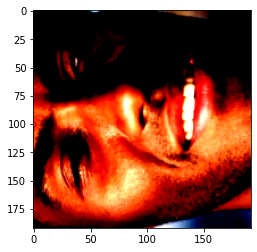

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
#Transfomerの作成
preprocess = transforms.Compose([
    transforms.Resize(256), #(256,256)に画像をリサイズ
    transforms.CenterCrop(192), #画像の中心に合わせて(224,224)で切り抜く
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #RGBチャンネルごとに平均、分散で標準化
])

'''
#画像の前処理
input_image = Image.open(filename).convert('RGB')

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to(device) # バッチ次元を追加する。(C,H,W)→(1,C,H,W)
'''

#Dataset
#transformにある操作をなされた画像が出てくる(大体正規化されたtensor)

class VGG_Img_Dataset(data.Dataset):

  def __init__(self, file_list, transform):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    return len(self.file_list)

  #特殊メソッドなので自動的に呼び出される
  def __getitem__(self, index):
    img_path = self.file_list[index]
    img = Image.open(img_path).convert('RGB')
    img_transformed = self.transform(img)
    return img_transformed

import matplotlib.pyplot as plt

train_dataset = VGG_Img_Dataset(train_img_list,preprocess)
train_dataset.__getitem__(0)

#前処理後のデータを表示してみる
plt.imshow(train_dataset.__getitem__(50).T)


In [ ]:
#DataLoaderの作成
batch_size = 1

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([batch_size, 3, 224, 224])

torch.Size([1, 3, 192, 192])


In [ ]:
#model

#数値は畳み込み層の出力数、”M” はプーリング層を表しています。これを _make_layers() に渡して、特徴抽出部分を組み立てます。
cfgs = {
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]
}

import torch
import torch.nn as nn
import cv2
import numpy as np

#VGG Encoder（特徴量抽出） + Image Decoder

#seed値を固定しておく（重みの再現性のため）
torch.manual_seed(0)

class Image_Autoencoder(nn.Module):
    def __init__(
        self,
        cfg,
        batch_norm=False,
        num_classes=1000,
        dropout=0.5,
        in_features=18432,
        bias=True
    ):
        
        super(Image_Autoencoder, self).__init__()
        self.encoder = self._make_encoder_layers(cfg, batch_norm)
        #self.decoder = self._make_decoder_layers()

        self.decoder_linear1 = nn.Linear(in_features, 10, bias=bias)
        self.decoder_linear2 = nn.Linear(10, 18432, bias=bias)
        self.decoder_convT1 = nn.ConvTranspose2d(18432, 256, kernel_size=6, padding=0, stride=1, dilation=2, output_padding=1)
        self.relu1 = nn.ReLU(True)
        self.decoder_convT2 = nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2)
        self.relu2 = nn.ReLU(True)
        self.decoder_convT3 = nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2)
        self.relu3 = nn.ReLU(True)
        self.decoder_convT4 = nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2)
        self.relu4 = nn.ReLU(True)
        self.decoder_convT5 = nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2)
        self.tanh = nn.Tanh()

        #分類器として使わないので今回はコメントアウト！
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # self.classifier = nn.Sequential(
        #     nn.Linear(512 * 7 * 7, 4096),
        #     nn.ReLU(True),
        #     nn.Dropout(p=dropout),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(True),
        #     nn.Dropout(p=dropout),
        #     nn.Linear(4096, num_classes),
        # )

    def forward(self, x):
        #x=[N,C,H,W]=[batch_num,3,224,224]
        x = self.encoder(x) #[N,512, 7, 7]
        #print(x.shape)
        x = x.view(1,1,1,-1) #[1,1,1,25088]
        #x = self.decoder(x)
        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.classifier(x)

        x = self.decoder_linear1(x) #[1,1,1,10]
        x = self.decoder_linear2(x) #[1,1,1,18432]
        x = torch.transpose(x,1,3) #[N,C,H,W]=[1,18432,1,1]にする。ConvTranspose2dの仕様。
        x = self.decoder_convT1(x) 
        x = self.relu1(x)
        x = self.decoder_convT2(x)
        x = self.relu2(x)
        x = self.decoder_convT3(x)
        x = self.relu3(x)
        x = self.decoder_convT4(x)
        x = self.relu4(x)
        x = self.decoder_convT5(x)
        x = self.tanh(x) 
        #print("output:",x.shape) #torch.Size([1, 3, 192, 192])
        
        '''
        #lossのために最小二乗法を計算したい。inputとoutputのimage sizeを合わせる
        print("x[0].shape:",x[0].shape)
        #out_img = x[0].to('cpu').detach().numpy().transpose(1, 2, 0) #[H,W,C]=[192,192,3]
        out_img = torchvision.transforms.functional.to_pil_image(x[0])
        #print("out_img.shape:",out_img.shape)
        #out_img = cv2.resize(out_img, (224, 224)) #[224,224,3]
        out_img = out_img.resize((224, 224))
        #print("resized_out_img.shape:",out_img.shape)

        plt.imshow(out_img)
        plt.show()

        # totensor = transforms.ToTensor() #[1,3,224,224]??
        # x = totensor(out_img)
        x = torchvision.transforms.functional.to_tensor(out_img)
        '''

        x = x.to(device)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def _make_encoder_layers(self, cfg, batch_norm):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(True)]
                else:
                    layers += [conv2d, nn.ReLU(True)]
                in_channels = v

        return nn.Sequential(*layers)

'''
    def _make_decoder_layers(self, in_features=512*7*7, bias = True):
        layers = []
        layers_content = [
                          #x=(N,1,1,in_features)
                          nn.Linear(in_features, 10, bias=bias),
                          nn.Linear(10, 18432, bias=bias),
                          #x=(N,1,1,in_features)→(N,in_features,1,1)にする。全結合層から畳み込み層に移るためのtensorの整形。

                          nn.ConvTranspose2d(18432, 256, kernel_size=6, padding=0, stride=1, dilation=2, output_padding=1),
                          nn.ReLU(True),
                          nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2),
                          nn.ReLU(True),
                          nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2),
                          nn.ReLU(True),
                          nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2),
                          nn.ReLU(True),
                          nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2),
                          nn.Tanh()]
        for layer in layers_content:
          layers += [layer]

        return nn.Sequential(*layers)
'''

'\n    def _make_decoder_layers(self, in_features=512*7*7, bias = True):\n        layers = []\n        layers_content = [\n                          #x=(N,1,1,in_features)\n                          nn.Linear(in_features, 10, bias=bias),\n                          nn.Linear(10, 18432, bias=bias),\n                          #x=(N,1,1,in_features)→(N,in_features,1,1)にする。全結合層から畳み込み層に移るためのtensorの整形。\n\n                          nn.ConvTranspose2d(18432, 256, kernel_size=6, padding=0, stride=1, dilation=2, output_padding=1),\n                          nn.ReLU(True),\n                          nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2),\n                          nn.ReLU(True),\n                          nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2),\n                          nn.ReLU(True),\n                          nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2),\n                          nn.ReLU(True),\n                          nn.

In [ ]:
'''
# 学習済みのVGG-11モデルをロード
# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg11(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)
'''

'\n# 学習済みのVGG-11モデルをロード\n# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります\n\n# VGG-16モデルのインスタンスを生成\nuse_pretrained = True  # 学習済みのパラメータを使用\nnet = models.vgg11(pretrained=use_pretrained)\nnet.eval()  # 推論モードに設定\n\n# モデルのネットワーク構成を出力\nprint(net)\n'

In [ ]:
#train code
import time
from tqdm.notebook import tqdm


def train_model(model, dataloader, num_epochs, lr, loss_epoch_list, loss_list):

    #GPU使えるか確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('使用デバイス：', device)

    #損失関数
    criterion = nn.MSELoss()

    mini_batch_size = 1

    model.to(device)

    #train mode
    model.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    print(num_train_imgs)
    batch_size = dataloader.batch_size

    #最適化手法
    #optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    optimizer.zero_grad()

    #画像表示
    input_list = []
    output_list = []

    with tqdm(range(num_epochs)) as pbar_epoch:

        for epoch in pbar_epoch:

            #開始時刻の保存
            t_epoch_start = time.time()
            epoch_loss = 0.0

            print('-------------------')
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('-------------------')
            print('(train)')

            pbar_epoch.set_description("[Epoch %d]" % (epoch))

            
            with tqdm(dataloader,
                      total=len(dataloader),
                      leave=False) as pbar_loss:
            

                for images in pbar_loss:
                
                    images = images.to(device)

                    #print('input image:',images.shape)

                    outputs = model(images).to(device)

                    #from IPython.core.debugger import Pdb; Pdb().set_trace()            
                  
                    # 誤差を計算
                    loss = criterion(outputs, images)

                    #loss.requires_grad = True

                    #逆伝播
                    loss.backward()
                    #stepってなんだ？
                    optimizer.step()

                    loss_epoch_list.append(loss)

                    #print(images.shape)
                    #print(outputs.shape)

                    images = images[0]#.permute(0,2,3,1)
                    outputs = outputs[0]#.permute(0,2,3,1)
                    #outputs = outputs.detach().cpu().numpy().transpose(0,2,3,1)

                    #print("reshaped:",images.shape)

                    input_list.append(images)
                    output_list.append(outputs)

            #------------
            #3.記録
            #------------

            loss_list.append(torch.mean(torch.stack(loss_epoch_list)))
            

            t_epoch_finish = time.time()
            print('---------------')
            print('epoch{} || Epoch_loss:{:.4f}'.format(
                epoch, torch.mean(torch.stack(loss_epoch_list))))

            print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
            t_epoch_start = time.time()

            loss_epoch_list = []

            #epoch毎の画像表示
            #torchvision.utils.make_gridはlistで渡す場合はbatchの次元消さないといけないっぽい
            input_images = torchvision.utils.make_grid(input_list,nrow=5,)
            output_images = torchvision.utils.make_grid(output_list)

            input_images = input_images.detach().cpu().numpy()
            output_images = output_images.detach().cpu().numpy()

            plt.imshow(input_images.transpose(1,2,0))
            plt.show()

            plt.imshow(output_images.transpose(1,2,0))
            plt.show()

            input_list = []
            output_list = []

        weight_path = '/content/drive/MyDrive/自分用/BMI/BMI_weight'

        torch.save(model.state_dict(), weight_path + "/weight_batch_1.pth")
        print("model was saved as:", weight_path + "/weight_batch_1.pth")

        #model.eval()

        plt.


        return model, loss_list

In [ ]:
#loss
def loss_func(input_data, output):

    #平均二乗誤差
    mseloss = nn.MSELoss()
    mse = mseloss(input_data, output)

    loss = mse

    return loss, mse


#VGG事前学習モデルを転移学習

使用デバイス： cuda:0
92


  0%|          | 0/10 [00:00<?, ?it/s]

-------------------
Epoch 0/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch0 || Epoch_loss:1.3890
timer: 16.6072 sec.


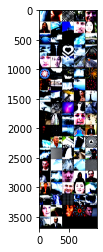

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


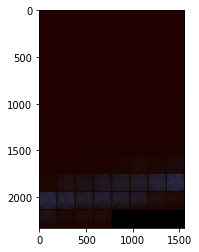

0
-------------------
Epoch 1/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch1 || Epoch_loss:1.3799
timer: 16.5985 sec.


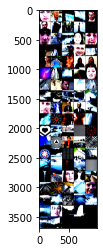

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


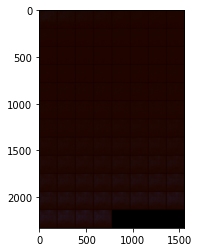

1
-------------------
Epoch 2/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch2 || Epoch_loss:1.3476
timer: 16.7228 sec.


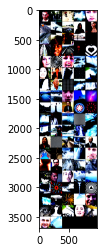

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


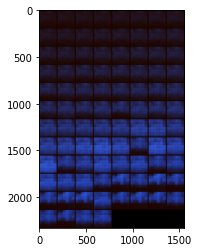

3
-------------------
Epoch 3/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch3 || Epoch_loss:1.3258
timer: 16.7536 sec.


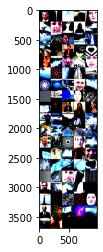

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


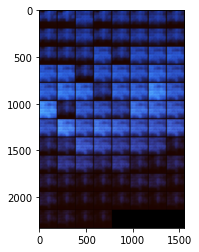

6
-------------------
Epoch 4/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch4 || Epoch_loss:1.3184
timer: 16.8084 sec.


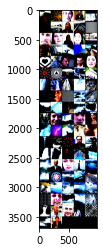

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


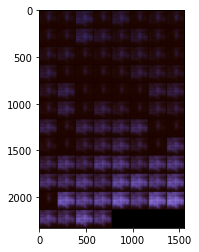

10
-------------------
Epoch 5/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch5 || Epoch_loss:1.2925
timer: 16.5395 sec.


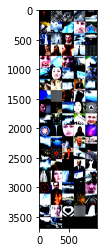

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


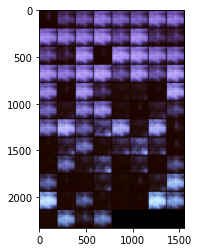

15
-------------------
Epoch 6/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch6 || Epoch_loss:1.2623
timer: 16.5840 sec.


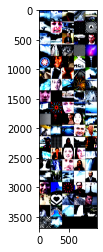

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


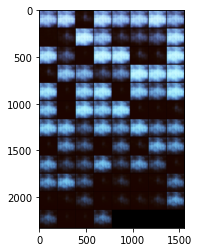

21
-------------------
Epoch 7/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch7 || Epoch_loss:1.2320
timer: 16.5646 sec.


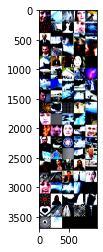

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


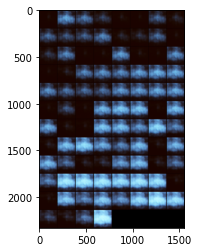

28
-------------------
Epoch 8/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch8 || Epoch_loss:1.2300
timer: 16.6368 sec.


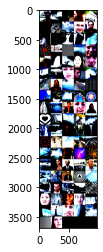

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


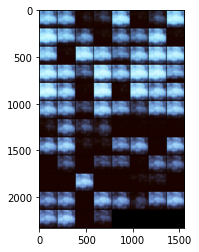

36
-------------------
Epoch 9/10
-------------------
(train)


  0%|          | 0/92 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
epoch9 || Epoch_loss:1.1653
timer: 16.4393 sec.


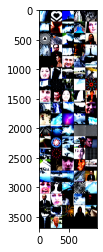

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


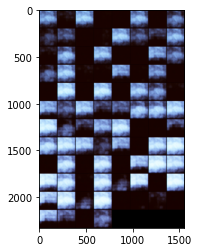

45
model was saved as: /content/drive/MyDrive/自分用/BMI/BMI_weight/weight_batch_1.pth


(Image_Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (12): ReLU(inplace=True)
     (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (14): ReLU(inplace=True)
     (15): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [ ]:
#train

model = Image_Autoencoder(cfgs["A"])
#lossの可視化のため
loss_epoch_list = []
loss_list = []

train_model(model, train_dataloader, 10, 1e-5, loss_epoch_list, loss_list)

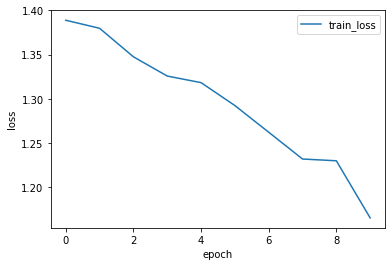

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_list, label="train_loss")
plt.legend()
plt.show()

In [ ]:
#validation
a=[]

def append_list

In [ ]:
#output_image


In [ ]:
#frature map